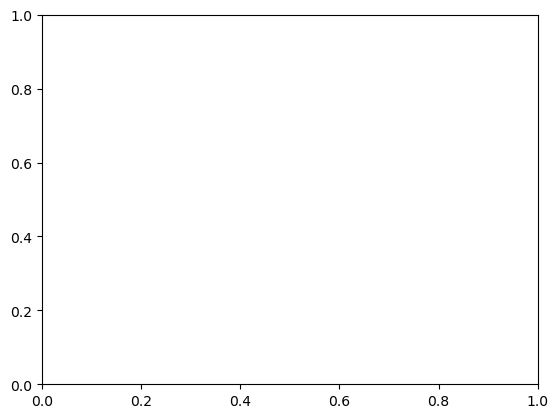

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import genfromtxt
import scipy.integrate as integrate
import endf
import pandas as pd
import os
fig,ax=plt.subplots()

In [2]:
element_symbols=['H','He','Li','Be','B','C','N','O','F','Ne','Na','Mg','Al','Si','P','S','Cl','Ar','K','Ca','Sc','Ti','V','Cr','Mn','Fe','Co','Ni','Cu','Zn','Ga','Ge','As','Se','Br','Kr','Rb','Sr','Y','Zr','Nb','Mo','Tc','Ru','Rh',	'Pd','Ag','Cd','In','Sn','Sb','Te',	'I','Xe','Cs','Ba','La','Ce','Pr','Nd','Pm','Sm','Eu','Gd','Tb','Dy','Ho','Er','Tm','Yb','Lu','Hf','Ta','W','Re','Os','Ir','Pt','Au','Hg','Tl','Pb','Bi','Po','At','Rn','Fr','Ra','Ac','Th','Pa','U','Np','Pu','Am','Cm','Bk','Cf','Es','Fm','Md','No']

# Set up units (working in CGS system)
barn=1.e-24 #cm^2

# MT IDs of reactions under consideration
reaction_ids=[16,17,18,102,103]
reaction_strs=["(n,2n)","(n,3n)","(n,fission)","(n,$\gamma$)","(n,p)"]




<>:8: SyntaxWarning: invalid escape sequence '\g'
<>:8: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipykernel_7108/1490970398.py:8: SyntaxWarning: invalid escape sequence '\g'
  reaction_strs=["(n,2n)","(n,3n)","(n,fission)","(n,$\gamma$)","(n,p)"]


In [3]:
# csv file with the edges of the energy groups
neutronspec_edges = genfromtxt('/mnt/c/Users/michael.weekes/OneDrive - Newcleo/Documenti/placement 2/orion/MPR tests/LFR30_neutronspec_groupedges.csv', delimiter=',')
print(neutronspec_edges)


n_energy_bins=len(neutronspec_edges)-1
# group cross-section data according to the neutron spec group structure

neutronspec_central = genfromtxt('/mnt/c/Users/michael.weekes/OneDrive - Newcleo/Documenti/placement 2/orion/MPR tests/LFR30_neutronspec_values.csv', delimiter=',')


[1.01204380e-01 5.40881657e-01 3.98584064e+00 8.47376189e+00
 1.36243385e+01 2.25261156e+01 4.04997497e+01 6.79030187e+01
 9.10483536e+01 1.48448948e+02 3.06903424e+02 4.53780421e+02
 7.39862098e+02 1.24047359e+03 2.05096574e+03 3.29759696e+03
 5.52884374e+03 9.14124185e+03 1.51138839e+04 2.46422925e+04
 4.07429052e+04 6.73632260e+04 1.08308376e+05 1.81592868e+05
 3.00240774e+05 5.03392119e+05 8.09367163e+05 1.33818595e+06
 2.21252073e+06 3.65812240e+06 5.96435189e+06 9.86129934e+06
 1.95506490e+07]


In [ ]:
# Get JEFF 3.3 reaction cross-sections

# Select element, isotope and reaction (by MT ID)
lib_dir='/mnt/c/Users/michael.weekes/OneDrive - Newcleo/Documenti/placement 2/orion/MPR tests/ace_900/'

jeff_reactions = genfromtxt('/mnt/c/Users/michael.weekes/OneDrive - Newcleo/Documenti/placement 2/orion/MPR tests/JEFF_reactions.csv', delimiter=',')

n_reactions=len(jeff_reactions[:,0])

#test_A=115
#test_reaction_id=102

# Get Z from element symbol

for i in range(n_reactions):
    parent_ZAI=jeff_reactions[i,0]

    test_reaction_id=jeff_reactions[i,1]

    meta_flag=np.mod(parent_ZAI,10)
    #print(meta_flag)
    #print("%i, %s, %i" % (parent_ZAI,ZAI_str,meta_flag))
    parent_ZA=parent_ZAI-meta_flag

    parent_Z=int(parent_ZA/10000)
    parent_A=int(((parent_ZA)-(10000*parent_Z))/10)

    if(meta_flag==1): meta_str="m"
    else: meta_str="g"

    element=element_symbols[parent_Z-1]
    filename="%i-%s-%i%s-900.ace" % (parent_Z,element,parent_A,meta_str)

    infile_str=lib_dir+filename

    table = endf.ace.get_table(infile_str)

    test_reaction = (table.interpret().reactions[test_reaction_id].xs)['900K']



    d1 = {'Energy': test_reaction.x, 'Sigma': test_reaction.y}
    test_df=pd.DataFrame(data=d1)

    # group cross-section data according to the neutron spec group structure
    grouped_xs_df=test_df.groupby(pd.cut(test_df["Energy"],neutronspec_edges),observed=False).mean()

    grouped_xs_df=grouped_xs_df.Sigma.reset_index()
    grouped_xs=grouped_xs_df["Sigma"].copy()

    # bit of a bodge - fixes any empty bins in the middle of the range
    for i in range(1,n_energy_bins-1):
        if np.isnan(grouped_xs[i]):
            grouped_xs[i]=0.5*(grouped_xs[i-1]+grouped_xs[i+1])


    prod_sum=0
    flux_sum=0
    for i in range(len(grouped_xs)):
        if(np.isnan(grouped_xs[i])): grouped_xs[i]=0
        prod_sum+=grouped_xs[i]*neutronspec_central[i]#*neutronspec_binwidths[i]
        flux_sum+=neutronspec_central[i]#*neutronspec_binwidths[i]


    if test_reaction_id==16:
        daughter_Z=parent_Z
        daughter_A=parent_A-1
    if test_reaction_id==17:
        daughter_Z=parent_Z
        daughter_A=parent_A-2
    if test_reaction_id==102:
        daughter_Z=parent_Z
        daughter_A=parent_A+1
    if test_reaction_id==103:
        daughter_Z=parent_Z-1
        daughter_A=parent_A
    if test_reaction_id==18:
        daughter_Z=0
        daughter_A=0
    daughter_ZAI=(daughter_Z*10000)+(daughter_A*10)
    print("%i,%i,%i,%.5e" % (parent_ZAI,test_reaction_id,daughter_ZAI,(prod_sum/flux_sum)))




10010,102,10020,1.30521e-04
10020,16,10010,2.19053e-03
10020,102,10030,3.88976e-06
10030,16,10020,1.84957e-04
20030,102,20040,4.32218e-05
20030,103,10030,2.20045e+00
30060,102,30070,2.17603e-05
30060,103,20060,1.15744e-03
30070,16,30060,7.40213e-05
30070,102,30080,2.74627e-05
40090,102,40100,1.19896e-05
40090,103,30090,1.60790e-06
50100,102,50110,2.30500e-04
50100,103,40100,2.65146e-03
50110,16,50100,1.31599e-05
50110,102,50120,5.01910e-04
50110,103,40110,4.60958e-06
60130,16,60120,1.86288e-04
60130,17,60110,0.00000e+00
60130,102,60140,4.97568e-05
60130,103,50130,9.65650e-06
70140,16,70130,1.17910e-05
70140,102,70150,4.93574e-05
70140,103,60140,2.82509e-02
70150,16,70140,1.67578e-04
70150,102,70160,1.39822e-05
70150,103,60150,2.28676e-05
80160,16,80150,1.21701e-06
80160,102,80170,9.99384e-05
80160,103,70160,5.91352e-05
80170,16,80160,6.30216e-04
80170,17,80150,0.00000e+00
80170,102,80180,5.20073e-04
80170,103,70170,1.32853e-05
80180,16,80170,7.17439e-04
80180,17,80160,3.21331e-05
80180

In [ ]:
# Get remaining ENDF reaction cross-sections

# Select element, isotope and reaction (by MT ID)
lib_dir='/mnt/c/Users/michael.weekes/OneDrive - Newcleo/Documenti/placement 2/orion/MPR tests/Lib80x/Lib80x/Lib80x/'

missing_reactions = genfromtxt('/mnt/c/Users/michael.weekes/OneDrive - Newcleo/Documenti/placement 2/orion/MPR tests/reactions_in_endf_not_jeff.csv', delimiter=',')

n_reactions=len(missing_reactions[:,0])

#test_A=115
#test_reaction_id=102

# Get Z from element symbol

for i in range(n_reactions):
    parent_ZAI=missing_reactions[i,0]

    test_reaction_id=missing_reactions[i,1]

    meta_flag=np.mod(parent_ZAI,10)
    #print("%i, %s, %i" % (parent_ZAI,ZAI_str,meta_flag))
    file_ZA=int(parent_ZAI/10)
    parent_Z=int(parent_ZAI/10000)
    parent_A=int((parent_ZAI-(10000*parent_Z))/10)

    if(meta_flag==1): meta_str="m1_"
    else: meta_str=""

    element=element_symbols[parent_Z-1]
    #print(meta_str)
    #print(file_ZA)

    filename="%s/%s%i.802nc" % (element,meta_str,file_ZA)

    infile_str=lib_dir+filename

    table = endf.ace.get_table(infile_str)

    test_reaction = (table.interpret().reactions[test_reaction_id].xs)['900K']



    d1 = {'Energy': test_reaction.x, 'Sigma': test_reaction.y}
    test_df=pd.DataFrame(data=d1)

    # group cross-section data according to the neutron spec group structure
    grouped_xs_df=test_df.groupby(pd.cut(test_df["Energy"],neutronspec_edges),observed=False).mean()

    grouped_xs_df=grouped_xs_df.Sigma.reset_index()
    grouped_xs=grouped_xs_df["Sigma"].copy()

    # bit of a bodge - fixes any empty bins in the middle of the range
    for i in range(1,n_energy_bins-1):
        if np.isnan(grouped_xs[i]):
            grouped_xs[i]=0.5*(grouped_xs[i-1]+grouped_xs[i+1])


    prod_sum=0
    flux_sum=0
    for i in range(len(grouped_xs)):
        if(np.isnan(grouped_xs[i])): grouped_xs[i]=0
        prod_sum+=grouped_xs[i]*neutronspec_central[i]#*neutronspec_binwidths[i]
        flux_sum+=neutronspec_central[i]#*neutronspec_binwidths[i]


    if test_reaction_id==16:
        daughter_Z=parent_Z
        daughter_A=parent_A-1
    if test_reaction_id==17:
        daughter_Z=parent_Z
        daughter_A=parent_A-2
    if test_reaction_id==102:
        daughter_Z=parent_Z
        daughter_A=parent_A+1
    if test_reaction_id==103:
        daughter_Z=parent_Z-1
        daughter_A=parent_A
    if test_reaction_id==18:
        daughter_Z=0
        daughter_A=0
    daughter_ZAI=(daughter_Z*10000)+(daughter_A*10)
    #print("For reaction %i on nuclide %s-%i, onegroup XS = %.3e" % (test_reaction_id,element,test_A,(prod_sum/flux_sum)))
    #print("%s,%i,%i,%i,%s,%i,%.5e" % (element,test_Z,test_A,metastable_flag,reaction_strs[reaction_ids.index(test_reaction_id)],test_reaction_id,(prod_sum/flux_sum)))
    print("%i,%i,%i,%.5e" % (parent_ZAI,test_reaction_id,daughter_ZAI,(prod_sum/flux_sum)))




40070,103,30070,9.78219e+00
40090,16,40080,2.66278e-02
60120,102,60130,2.75146e-05
60120,103,50120,1.84733e-05
240500,16,240490,7.35135e-05
240500,103,230500,1.38954e-02
240530,16,240520,1.94751e-03
240530,103,230530,1.86333e-04
240540,16,240530,1.13970e-03
240540,103,230540,2.30900e-05
270590,17,270570,6.30998e-09
280610,17,280590,0.00000e+00
280640,17,280620,4.44459e-05
300690,16,300680,3.97677e-03
300690,102,300700,5.96735e-02
300690,103,290690,6.52252e-05
310700,16,310690,2.26620e-03
310700,102,310710,1.12150e-01
310700,103,300700,1.84347e-03
320710,16,320700,2.39445e-03
320710,102,320720,1.86228e-01
320710,103,310710,1.56965e-03
320750,16,320740,4.53389e-03
320750,102,320760,6.35694e-02
320750,103,310750,2.80289e-05
340810,16,340800,4.42462e-03
340810,102,340820,5.74507e-02
340810,103,330810,1.79014e-05
350800,16,350790,2.77985e-03
350800,102,350810,2.54080e-01
350800,103,340800,3.44358e-02
360790,16,360780,1.68574e-03
360790,102,360800,2.03198e-01
360790,103,350790,9.56587e-02
36